In [181]:
import torch
import torchvision
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import mplcyberpunk
plt.style.use('cyberpunk')

In [182]:
# check the version of torch and torchvision
print(torch.__version__, torchvision.__version__)

# setup device agnoustic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu128 0.23.0+cu128
cpu


### Loading, Exploring and Preparing the dataset

we are going to use FashionMNIST Dataset from torch vision

In [183]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

X_train, y_train = training_data.data.to(device), training_data.targets.to(device)
X_test, y_test = testing_data.data.to(device), testing_data.targets.to(device)

labels = training_data.classes

In [184]:
print(type(X_train), type(y_train), type(X_test), type(y_test))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


Inspect the data size, type and shape of the training and testing data

In [185]:
# Inspection of the training data
print(f"Training data features: shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"Training data targets: shape: {y_train.shape}, dtype: {y_train.dtype}")

# Inspection of the testing data
print(f"Testing data features: shape: {X_test.shape}, dtype: {X_test.dtype}")
print(f"Testing data targets: shape: {y_test.shape}, dtype: {y_test.dtype}")

Training data features: shape: torch.Size([60000, 28, 28]), dtype: torch.uint8
Training data targets: shape: torch.Size([60000]), dtype: torch.int64
Testing data features: shape: torch.Size([10000, 28, 28]), dtype: torch.uint8
Testing data targets: shape: torch.Size([10000]), dtype: torch.int64


We are now going to inspect samples of the data to see the data in random positions

In [186]:
print("Sample training data")
print(X_train[0])

print("sample of training targres")
print(y_train[:10])

print("training labels are")
print(labels)

Sample training data
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,  

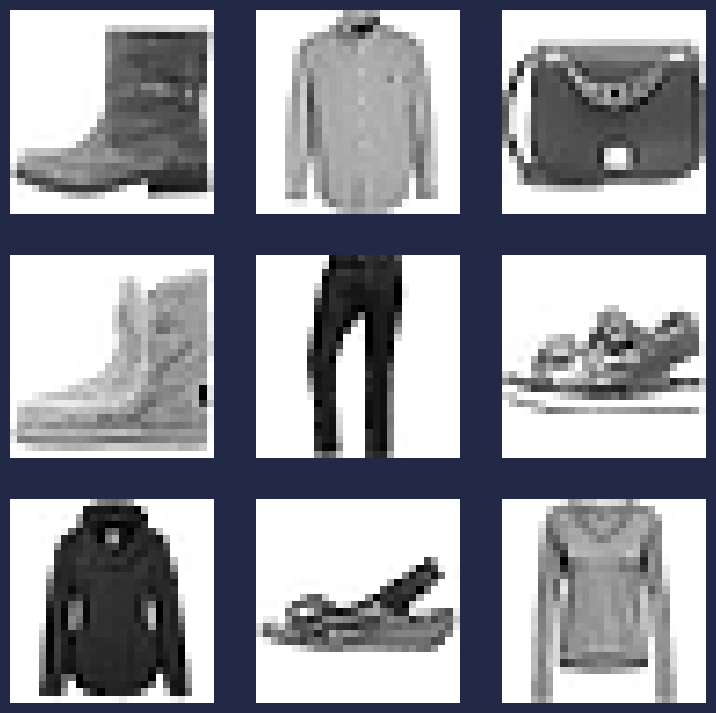

In [189]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    idx = torch.randint(0, len(X_train), (1,)).item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(X_train[idx] / 255, cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()
